In [1]:
import os

import pandas as pd
import io
import requests
import numpy as np
import math
import itertools    

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras

print(tf.version)

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam

import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTrain.head()

print(dataTrain.shape)
dataTrain.head()

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>
(3772, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


In [2]:
del dataTrain[22]
del dataTrain[23]

In [3]:
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


In [4]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)
inputTrain.head()        

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00060,0.015,0.120,0.082,0.146
1,0.24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.030,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00190,0.024,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00090,0.017,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00025,0.026,0.139,0.090,0.153


In [5]:
#Target data
outputTrain = dataTrain[21] - 1
outputTrain.head()

0    2
1    2
2    2
3    2
4    2
Name: 21, dtype: int64

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


In [7]:
del dataTest[22]
del dataTest[23]

In [8]:
inputTest = dataTest.drop([21], axis=1)
outputTest = dataTest[21] - 1

In [9]:
scaler = preprocessing.MinMaxScaler()
# fit using the train set
scaler.fit(inputTrain)
# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

In [10]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

In [11]:
'''print("Proporção das classes no dataset")
counts = np.bincount(outputTrain)
print(counts)
print("Dados de Treinamento:",  counts/ float(len(outputTrain)))
print("Dados de Teste:", np.bincount(outputTest) / float(len(outputTest)))

peso_classe1 = 1.0/counts[0]
peso_classe2 = 1.0/counts[1]
peso_classe3 = 1.0/counts[2]
'''

class_weights = compute_class_weight('balanced', np.unique(outputTrain), outputTrain)
print(class_weights)
d_class_weights = dict(enumerate(class_weights))

[13.51971326  6.58289703  0.36047401]


In [12]:
 X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
     xtrainN, 
     outputTrain_one_hot, 
     test_size = 0.3, 
     random_state = 1, 
     stratify=outputTrain
 )  

In [13]:
model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 137,987
Trainable params: 137,987
Non-trainable params: 0
__________________________________________________

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
14/14 [==============================] - 17s 115ms/step - loss: 0.6539 - fn: 841.0797 - fp: 114.1139 - tn: 1669.5051 - tp: 50.7298 - precision: 0.3073 - recall: 0.1009 - val_loss: 0.5529 - val_fn: 3275.6667 - val_fp: 115.0000 - val_tn: 6542.3335 - val_tp: 53.0000 - val_precision: 0.3155 - val_recall: 0.0161
Epoch 2/500
14/14 [==============================] - 0s 13ms/step - loss: 0.6292 - fn: 4602.5058 - fp: 115.0000 - tn: 9212.6190 - tp: 61.3036 - precision: 0.3414 - recall: 0.0130 - val_loss: 0.4865 - val_fn: 6782.8335 - val_fp: 118.0000 - val_tn: 14083.3330 - val_tp: 317.8333 - val_precision: 0.7183 - val_recall: 0.0443
Epoch 3/500
14/14 [==============================] - 0s 13ms/step - loss: 0.5929 - fn: 7674.1902 - fp: 130.7617 - tn: 16740.8570 - tp: 761.6193 - precision: 0.8445 - recall: 0.0885 - val_loss: 0.3885 - val_fn: 8947.0000

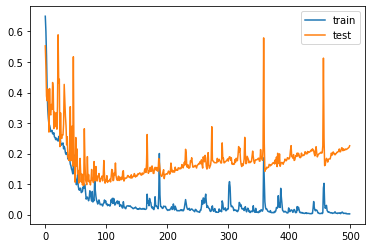

In [14]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("thyroid_model_at_epoch_{epoch}.h5")]

history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs=500,
    verbose=1,
    callbacks=callbacks,
    validation_data=(X_validation, y_validation),
    class_weight=d_class_weights,
)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


In [15]:
TrainPredictions = model.predict(inputTrain)
TrainPredictions = np.argmax(TrainPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

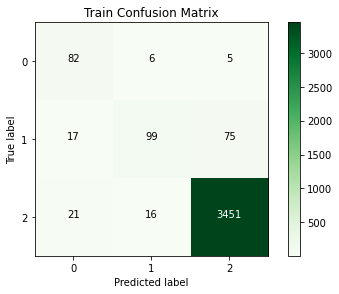

In [16]:
conf = confusion_matrix(outputTrain, TrainPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [17]:
print('Confusion Matrix\n')
print(conf)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTrain, TrainPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTrain, TrainPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTrain, TrainPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTrain, TrainPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTrain, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  82    6    5]
 [  17   99   75]
 [  21   16 3451]]

Accuracy: 0.96

Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.83
Macro Recall: 0.80
Macro F1-score: 0.80

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.88      0.77        93
     Class 2       0.82      0.52      0.63       191
     Class 3       0.98      0.99      0.98      3488

    accuracy                           0.96      3772
   macro avg       0.83      0.80      0.80      3772
weighted avg       0.96      0.96      0.96      3772



In [18]:
TestPredictions = model.predict(inputTest)
TestPredictions = np.argmax(TestPredictions, axis=1)

Text(0.5, 15.0, 'Predicted label')

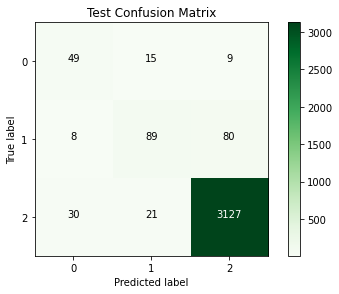

In [19]:
conf = confusion_matrix(outputTest, TestPredictions)

classes = [0, 1, 2]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Test Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [20]:
print('Confusion Matrix\n')
print(conf)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(outputTest, TestPredictions)))

print('Micro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(outputTest, TestPredictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(outputTest, TestPredictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(outputTest, TestPredictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(outputTest, TestPredictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(outputTest, TestPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[  49   15    9]
 [   8   89   80]
 [  30   21 3127]]

Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Macro Precision: 0.75
Macro Recall: 0.72
Macro F1-score: 0.73

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95

Classification Report

              precision    recall  f1-score   support

     Class 1       0.56      0.67      0.61        73
     Class 2       0.71      0.50      0.59       177
     Class 3       0.97      0.98      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.75      0.72      0.73      3428
weighted avg       0.95      0.95      0.95      3428

